In [2]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import country_converter as coco
import matplotlib.pyplot as plt

In [3]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [4]:
owid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=['date'], dayfirst = True, sep=',', skip_blank_lines = False)

In [5]:
db_conn.execute("DROP TABLE IF EXISTS owid CASCADE;")
owid = owid[(owid.location == 'Italy') | (owid.location=='Japan') | (owid.location == 'Netherlands')]
toDrop = ['continent','total_deaths','new_deaths','new_deaths_smoothed','total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million','total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities','life_expectancy',
       'human_development_index', 'excess_mortality_cumulative_absolute',
       'excess_mortality_cumulative', 'excess_mortality',
       'excess_mortality_cumulative_per_million']
toDrop = [x for x in toDrop if x in owid.columns]
owid.drop(toDrop, axis = 1, inplace=True)
owid.to_sql("owid", db_conn, if_exists='replace')
pd.read_sql_table('owid', db_conn)

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,hospital_beds_per_thousand
0,99031,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
1,99032,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
2,99033,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
3,99034,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
4,99035,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,141163,NLD,Netherlands,2022-10-05,8452092.0,0.0,2716.429,482929.883,0.000,155.209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2927,141164,NLD,Netherlands,2022-10-06,8452092.0,0.0,2716.429,482929.883,0.000,155.209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2928,141165,NLD,Netherlands,2022-10-07,8463695.0,11603.0,3156.143,483592.847,662.964,180.334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2929,141166,NLD,Netherlands,2022-10-08,8463695.0,NaN,NaN,483592.847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32


In [6]:
pd.unique(owid['iso_code'])

array(['ITA', 'JPN', 'NLD'], dtype=object)

In [7]:
db_conn.execute("DROP VIEW IF EXISTS owidWY CASCADE;")
query = '''
CREATE OR REPLACE VIEW owidWY AS 
SELECT *,
CAST(EXTRACT(WEEK FROM date) AS int) AS week,
CAST(EXTRACT(YEAR FROM date) AS int) AS year
FROM owid
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM owidWY',db_conn))

       index iso_code     location       date  total_cases  new_cases  \
0      99031      ITA        Italy 2020-01-31          2.0        2.0   
1      99032      ITA        Italy 2020-02-01          2.0        0.0   
2      99033      ITA        Italy 2020-02-02          2.0        0.0   
3      99034      ITA        Italy 2020-02-03          2.0        0.0   
4      99035      ITA        Italy 2020-02-04          2.0        0.0   
...      ...      ...          ...        ...          ...        ...   
2926  141163      NLD  Netherlands 2022-10-05    8452092.0        0.0   
2927  141164      NLD  Netherlands 2022-10-06    8452092.0        0.0   
2928  141165      NLD  Netherlands 2022-10-07    8463695.0    11603.0   
2929  141166      NLD  Netherlands 2022-10-08    8463695.0        NaN   
2930  141167      NLD  Netherlands 2022-10-09    8463695.0        NaN   

      new_cases_smoothed  total_cases_per_million  new_cases_per_million  \
0                    NaN                    0.0

In [8]:
#getting the relevant kpi data for cases
db_conn.execute("DROP VIEW IF EXISTS cases CASCADE;")
query = '''
CREATE OR REPLACE VIEW cases AS 
SELECT iso_code, date,new_cases_per_million, new_cases_smoothed_per_million, reproduction_rate
FROM owidWY
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM cases',db_conn))

     iso_code       date  new_cases_per_million  \
0         ITA 2020-01-31                  0.034   
1         ITA 2020-02-01                  0.000   
2         ITA 2020-02-02                  0.000   
3         ITA 2020-02-03                  0.000   
4         ITA 2020-02-04                  0.000   
...       ...        ...                    ...   
2926      NLD 2022-10-05                  0.000   
2927      NLD 2022-10-06                  0.000   
2928      NLD 2022-10-07                662.964   
2929      NLD 2022-10-08                    NaN   
2930      NLD 2022-10-09                    NaN   

      new_cases_smoothed_per_million  reproduction_rate  
0                                NaN                NaN  
1                                NaN                NaN  
2                                NaN                NaN  
3                                NaN                NaN  
4                                NaN                NaN  
...                              ...   

In [9]:
#getting the relevant kpi data for hospitalizations
db_conn.execute("DROP VIEW IF EXISTS hospitalizations, weeklyHos CASCADE;")
query = '''


CREATE OR REPLACE VIEW hospitalizations AS 
SELECT owidWY.iso_code, date, icu_patients_per_million, weekly_icu_admissions_per_million, hosp_patients_per_million
FROM owidWY
ORDER BY owidWY.iso_code ASC, date ASC
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM hospitalizations',db_conn))

     iso_code       date  icu_patients_per_million  \
0         ITA 2020-01-31                       NaN   
1         ITA 2020-02-01                       NaN   
2         ITA 2020-02-02                       NaN   
3         ITA 2020-02-03                       NaN   
4         ITA 2020-02-04                       NaN   
...       ...        ...                       ...   
2926      NLD 2022-10-05                     2.171   
2927      NLD 2022-10-06                     2.171   
2928      NLD 2022-10-07                     2.285   
2929      NLD 2022-10-08                       NaN   
2930      NLD 2022-10-09                       NaN   

      weekly_icu_admissions_per_million  hosp_patients_per_million  
0                                   NaN                        NaN  
1                                   NaN                        NaN  
2                                   NaN                        NaN  
3                                   NaN                        NaN  
4     

In [10]:
#getting the relevant kpi data for vaccinations
query = '''
CREATE OR REPLACE VIEW vaccinations AS 
SELECT iso_code, date, people_fully_vaccinated_per_hundred, total_boosters_per_hundred,new_vaccinations_smoothed_per_million
FROM owid
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM vaccinations',db_conn))

     iso_code       date  people_fully_vaccinated_per_hundred  \
0         ITA 2020-01-31                                  NaN   
1         ITA 2020-02-01                                  NaN   
2         ITA 2020-02-02                                  NaN   
3         ITA 2020-02-03                                  NaN   
4         ITA 2020-02-04                                  NaN   
...       ...        ...                                  ...   
2926      NLD 2022-10-05                                  NaN   
2927      NLD 2022-10-06                                  NaN   
2928      NLD 2022-10-07                                  NaN   
2929      NLD 2022-10-08                                  NaN   
2930      NLD 2022-10-09                                  NaN   

      total_boosters_per_hundred  new_vaccinations_smoothed_per_million  
0                            NaN                                    NaN  
1                            NaN                                    NaN

In [11]:
def simplePlot(db_conn,isoCode, factor, lastN=-1):
    df = pd.read_sql('SELECT * FROM ' + factor,db_conn)
    df = df[df.iso_code==isoCode]
    if lastN > 0:
        df = df.tail(lastN)
    kpis = [x for x in df.columns if not x in ['iso_code','date'] ]
    for kpi in kpis:
        print(kpi)
        plt.plot('date',kpi,data=df)
        plt.title(kpi + ' in ' + isoCode)
        plt.show()

icu_patients_per_million


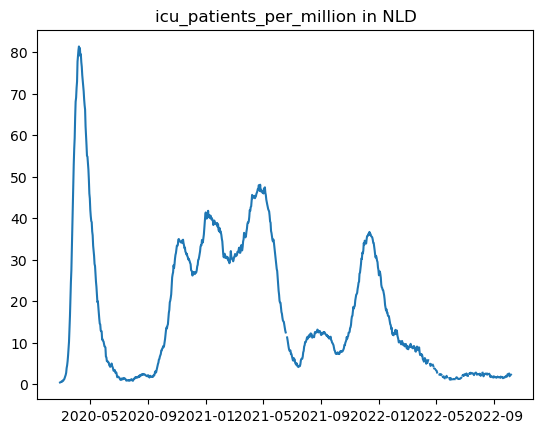

weekly_icu_admissions_per_million


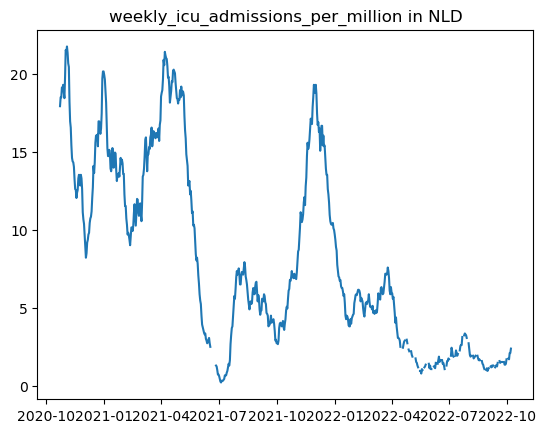

hosp_patients_per_million


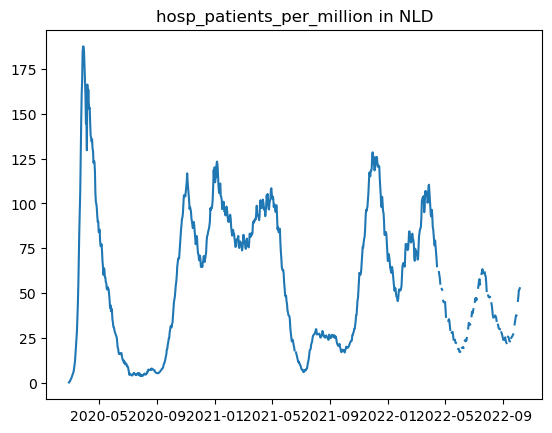

icu_patients_per_million


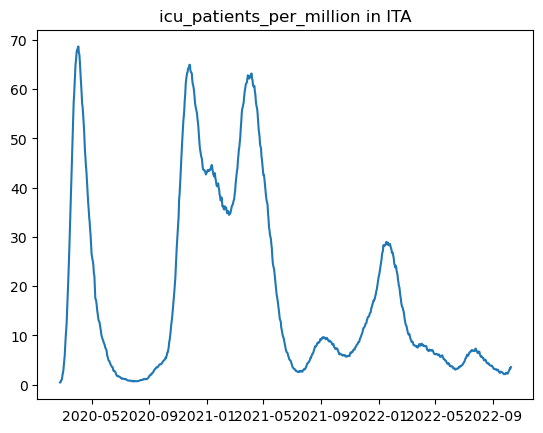

weekly_icu_admissions_per_million


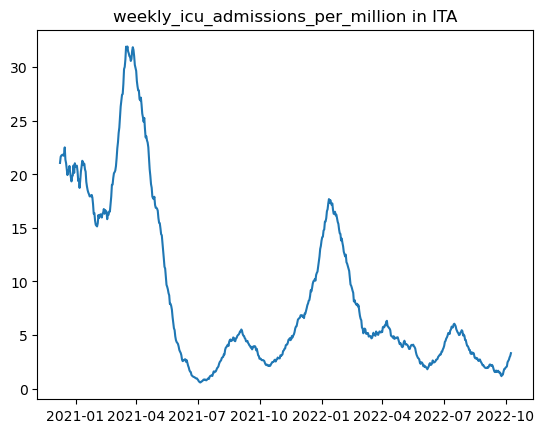

hosp_patients_per_million


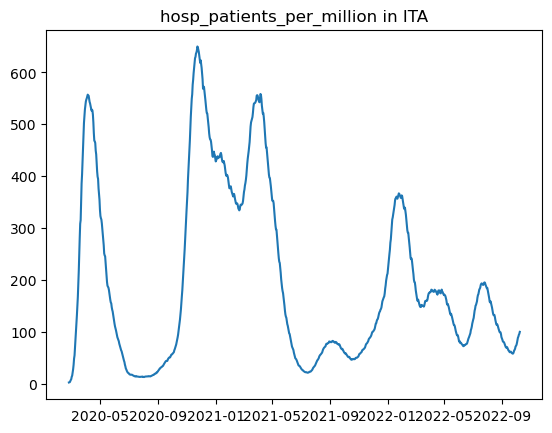

icu_patients_per_million


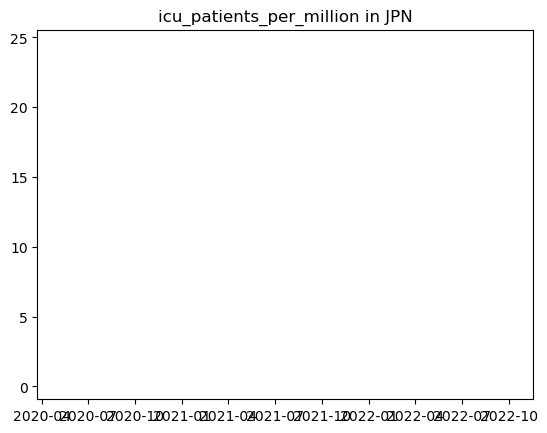

weekly_icu_admissions_per_million


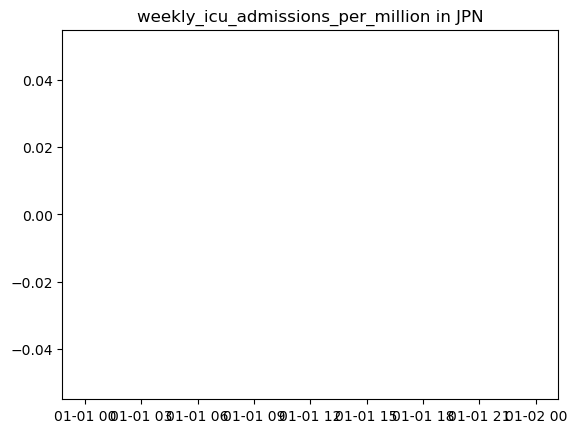

hosp_patients_per_million


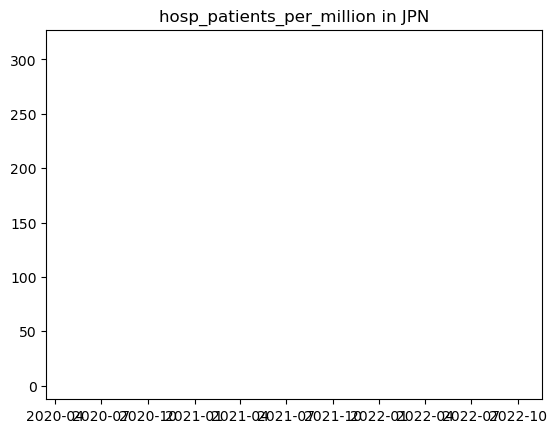

In [12]:
lastN = 1000
simplePlot(db_conn,'NLD','hospitalizations',lastN)
simplePlot(db_conn,'ITA','hospitalizations',lastN)
simplePlot(db_conn,'JPN','hospitalizations',lastN)

new_cases_per_million


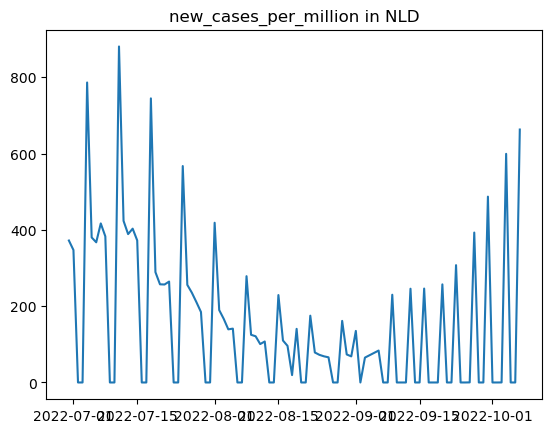

new_cases_smoothed_per_million


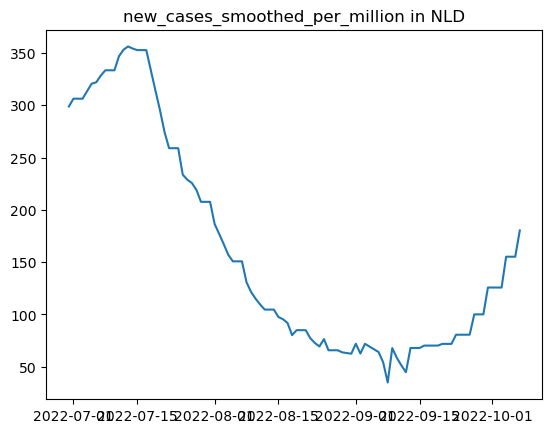

reproduction_rate


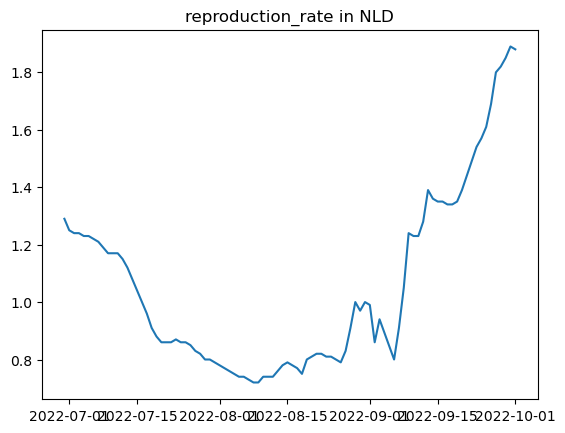

new_cases_per_million


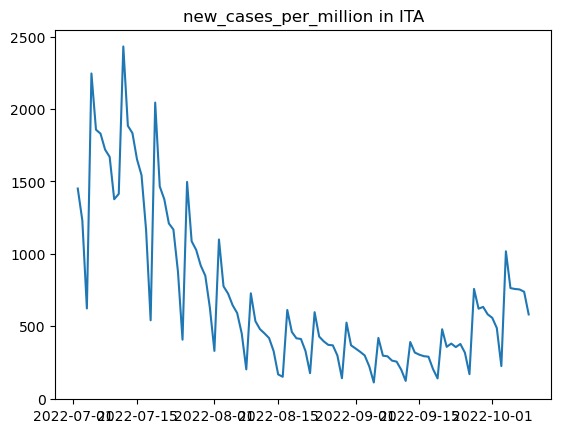

new_cases_smoothed_per_million


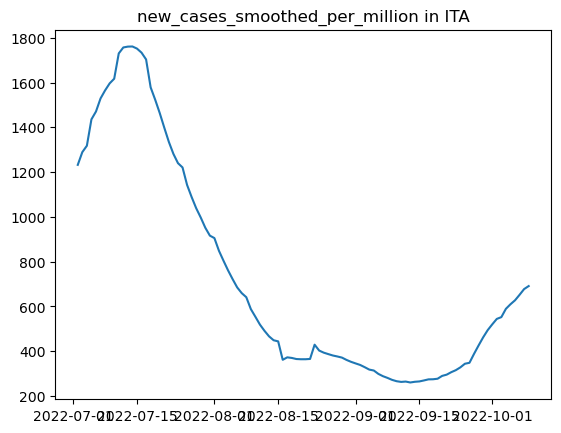

reproduction_rate


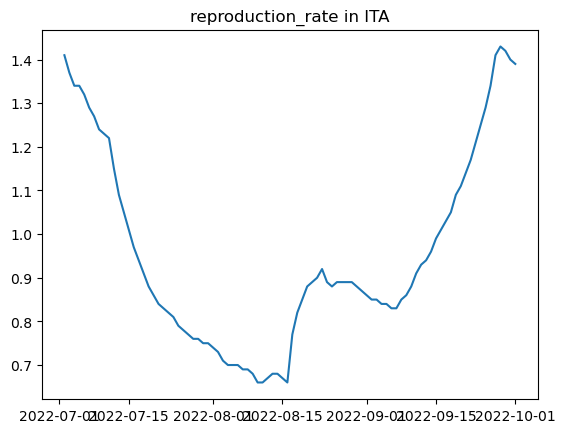

new_cases_per_million


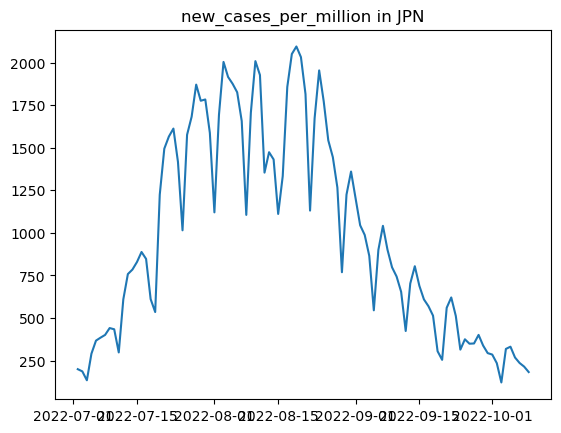

new_cases_smoothed_per_million


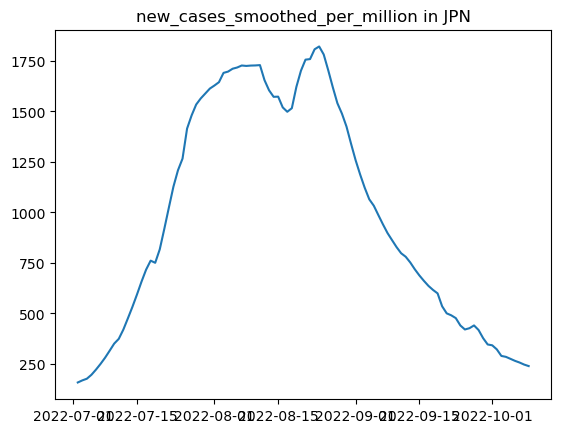

reproduction_rate


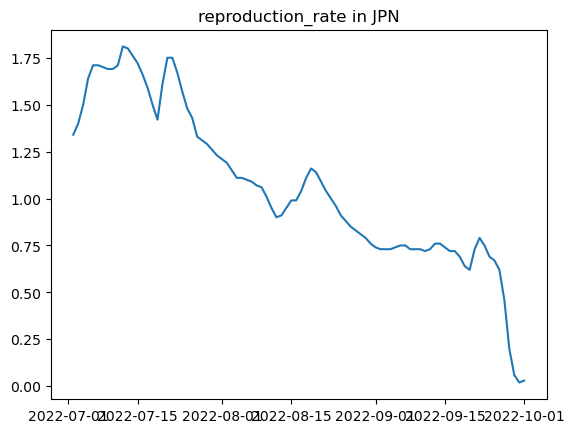

In [61]:
lastN = 100
simplePlot(db_conn,'NLD','cases',lastN)
simplePlot(db_conn,'ITA','cases',lastN)
simplePlot(db_conn,'JPN','cases',lastN)

people_fully_vaccinated_per_hundred


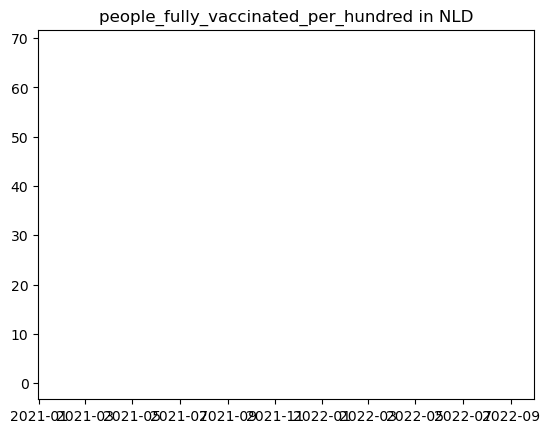

total_boosters_per_hundred


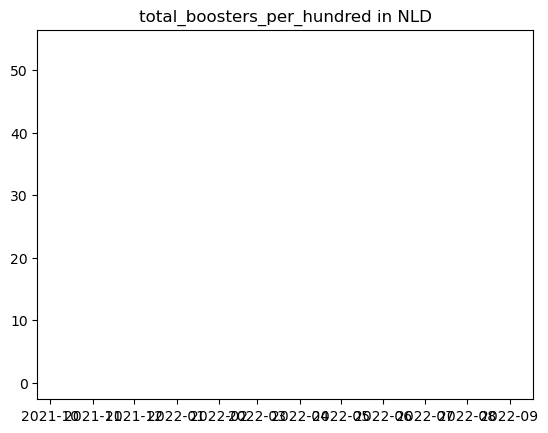

new_vaccinations_smoothed_per_million


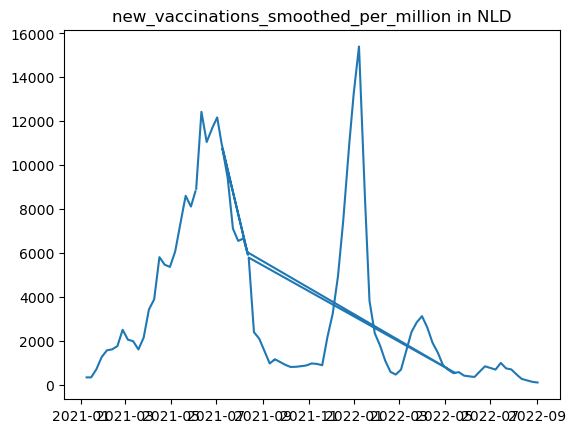

people_fully_vaccinated_per_hundred


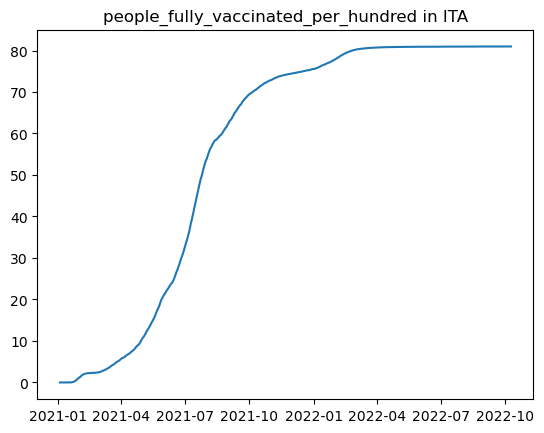

total_boosters_per_hundred


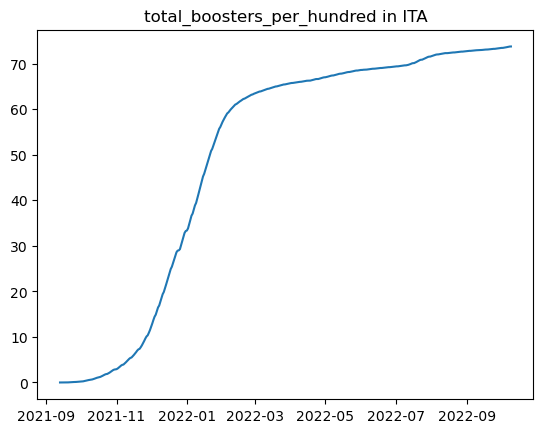

new_vaccinations_smoothed_per_million


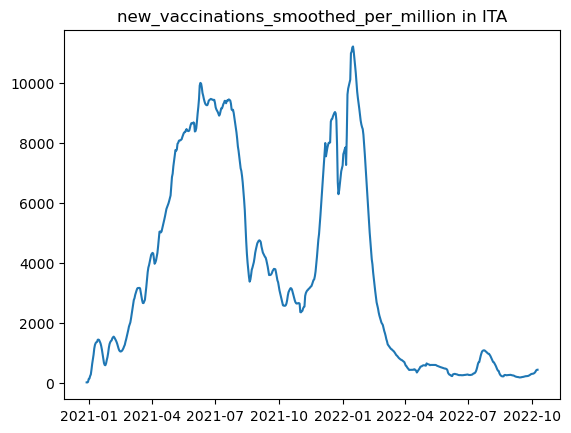

people_fully_vaccinated_per_hundred


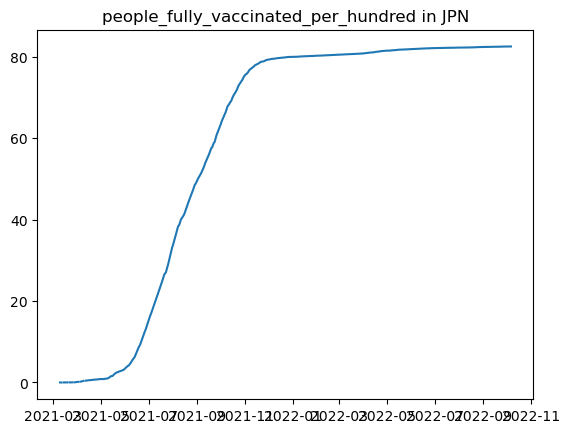

total_boosters_per_hundred


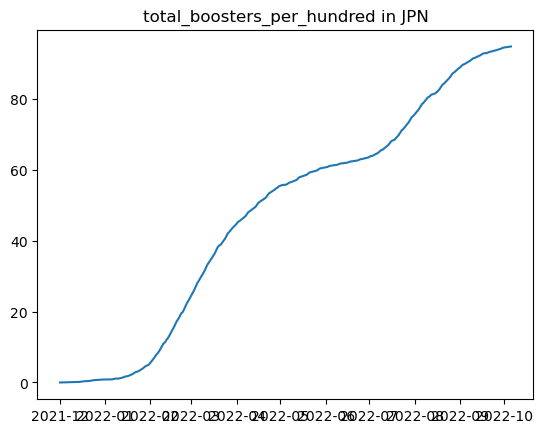

new_vaccinations_smoothed_per_million


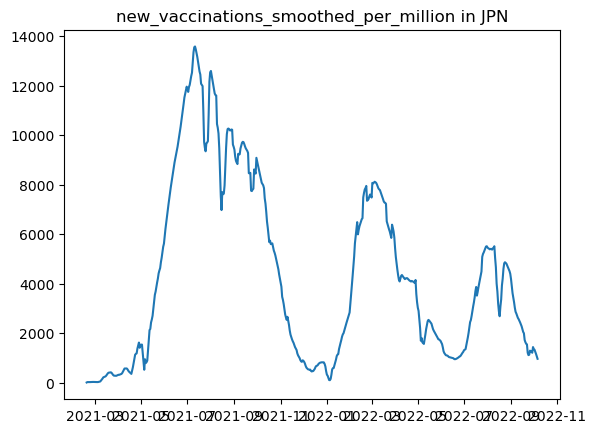

In [13]:
lastN = 1000
simplePlot(db_conn,'NLD','vaccinations',lastN)
simplePlot(db_conn,'ITA','vaccinations',lastN)
simplePlot(db_conn,'JPN','vaccinations',lastN)